Epoch 1/50
75/75 [==============================] - 23s 190ms/step - loss: 11.3930 - mae: 2.8272 - val_loss: 8.3237 - val_mae: 2.4787
Epoch 2/50
75/75 [==============================] - 9s 120ms/step - loss: 10.3111 - mae: 2.6986 - val_loss: 7.6012 - val_mae: 2.3991
Epoch 3/50
75/75 [==============================] - 9s 121ms/step - loss: 9.9044 - mae: 2.6401 - val_loss: 7.3005 - val_mae: 2.3554
Epoch 4/50
75/75 [==============================] - 10s 134ms/step - loss: 9.5824 - mae: 2.6048 - val_loss: 7.9631 - val_mae: 2.3977
Epoch 5/50
75/75 [==============================] - 9s 125ms/step - loss: 9.0694 - mae: 2.5404 - val_loss: 6.5885 - val_mae: 2.2512
Epoch 6/50
75/75 [==============================] - 11s 146ms/step - loss: 9.0026 - mae: 2.5141 - val_loss: 6.4390 - val_mae: 2.2094
Epoch 7/50
75/75 [==============================] - 10s 139ms/step - loss: 8.3910 - mae: 2.4186 - val_loss: 6.6621 - val_mae: 2.1993
Epoch 8/50
75/75 [==============================] - 9s 123ms/step - lo

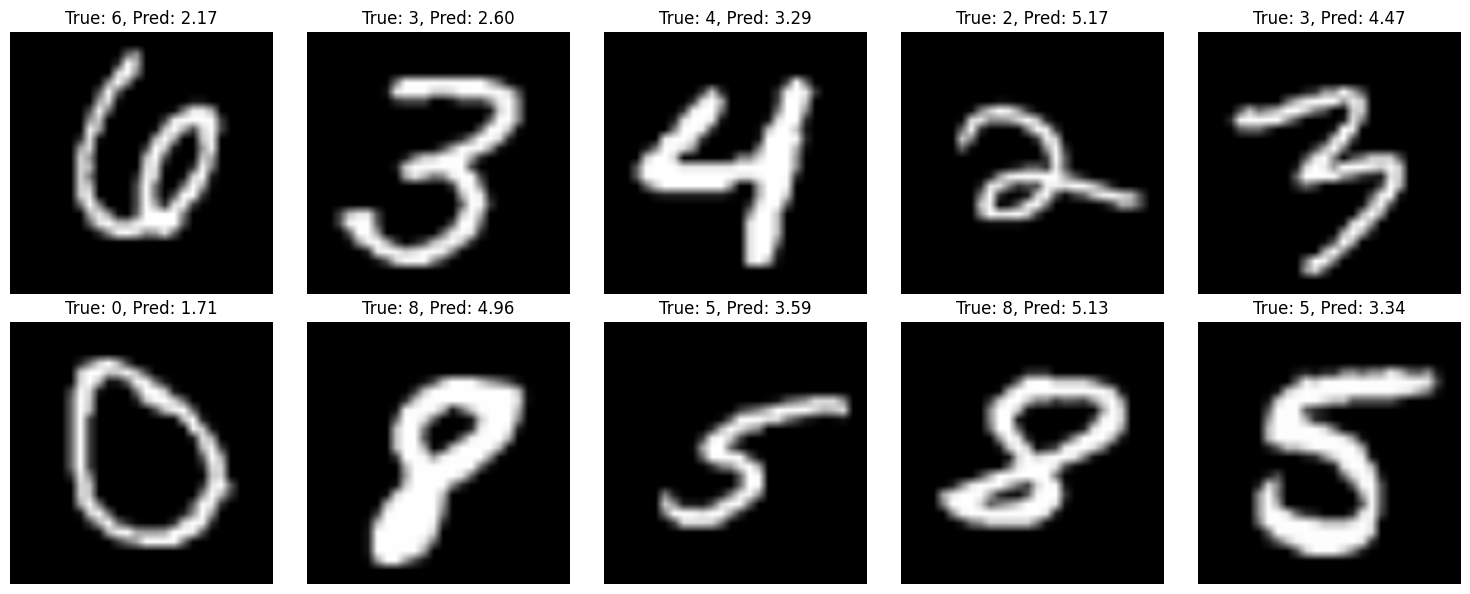

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


"""
# Define paths
image_folder = 'path_to_image_folder'
csv_file = 'path_to_csv_file.csv'

# Read the CSV file
df = pd.read_csv(csv_file)

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return img_array

# Load images and targets
images = []
targets = []

for index, row in df.iterrows():
    image_path = os.path.join(image_folder, row['image_name'])
    img_array = load_and_preprocess_image(image_path)
    images.append(img_array)
    targets.append(row['target'])

# Convert lists to arrays
images = np.vstack(images)
targets = np.array(targets)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, targets, test_size=0.2, random_state=42)
"""

# Load and preprocess the MNIST data
(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

# Normalize the images to [0, 1]
X_train_full = X_train_full / 255.0
X_test_full = X_test_full / 255.0

# Shuffle and randomly select 1,000 images from the training set
number_of_input_images = 3000
indices = np.random.choice(len(X_train_full), number_of_input_images, replace=False)
X_train = X_train_full[indices]
y_train = y_train_full[indices]

# Shuffle and randomly select 1,000 images from the test set
indices = np.random.choice(len(X_test_full), 100, replace=False)
X_test = X_test_full[indices]
y_test = y_test_full[indices]

# Resize and convert the images to 3 channels
def preprocess_images(images):
    images_resized = np.array([tf.image.resize_with_pad(tf.expand_dims(img, axis=-1), 224, 224) for img in images])
    images_rgb = np.concatenate([images_resized] * 3, axis=-1)
    return images_rgb

# Preprocess images
X_train = preprocess_images(X_train)
X_test = preprocess_images(X_test)

# Split the selected 1,000 images into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Base model for transfer learning (VGG16)
#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False  # Freeze the base model

# for layer in base_model.layers[-2:]:
#     layer.trainable = True

#Define the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1)  # Output layer for regression
])

"""
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1)  # Output layer for regression
])
"""

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Randomly pick 10 test images
random_indices = np.random.choice(len(X_test), 10, replace=False)
X_test_sample = X_test[random_indices]
y_test_sample = y_test[random_indices]

# Make predictions on the selected test images
y_pred_sample = model.predict(X_test_sample)

# Display the images along with their predicted and actual values
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_test_sample[i].reshape(224, 224, 3)[:, :, 0], cmap='gray')  # Show only one channel
    ax.set_title(f"True: {y_test_sample[i]}, Pred: {y_pred_sample[i][0]:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Optional: Save the model
model.save('mnist_regression_transfer_learning_model_1000_images.h5')

#hyper parameter tunning -> grid search/ bayesian opt
